<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/novel/combine_AandTnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime
import keras

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (352, 1216), antialias = True)
    img = img / 255.0
    return img'''

'def load_image(img_path):\n    img = tf.io.read_file(img_path)\n    img = tf.io.decode_jpeg(img, channels = 3)\n    img = tf.image.resize(img, size = (352, 1216), antialias = True)\n    img = img / 255.0\n    return img'

In [8]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (352 , 1216), antialias = True)
    img = img / 255.0
    return img

In [ ]:
def dataset_preposses(orig_img_path='/content/drive/MyDrive/generated_dataset/trans',hazy_img_path='/content/drive/MyDrive/generated_dataset/hazy',percentage=0.1,validation_size=200,test_size=64,seed_val=200):
    train_img = []
    val_img = []
    random.seed=seed_val
    orig_img = glob.glob(orig_img_path + '/*.png')
    n = len(orig_img)
    random.shuffle(orig_img)
    red_keys=orig_img[:]                                 #redundant keys to avoid key error
    train_keys = orig_img[:int(0.9*n*percentage)]
    #print(0.9*n*percentage)
    #print(len(train_keys))
    val_keys = orig_img[-int(0.1*n*percentage):]
    #print(len(val_keys))
    split_dict = {}
    #i=0
    for key in red_keys:
      split_dict[key]='red'
      #i+=1
    #print(i)
    for key in train_keys:
      split_dict[key] = 'train'
    for key in val_keys:
      split_dict[key] = 'val'
      
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    for img in hazy_img:
      
      img_name = img.split('/')[-1][:-4].split('_')[0]
      orig_path = orig_img_path + '/' + img_name+'.png'
      if (split_dict[orig_path] == 'train'):
        train_img.append([img, orig_path])
      if (split_dict[orig_path] == 'val'):
        val_img.append([img, orig_path])
      

    return train_img, val_img


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/kitti/gt'
  haze_pth='/content/drive/MyDrive/kitti/hazy'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [ ]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [ ]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img,0,training = False)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i],)
        #plt.imsave('plt'+filename,display_list[i])
    plt.show()

In [ ]:
ls /content/drive/MyDrive/nets/

a_net/                            modified_t_net/
a_net_0.1475.data-00000-of-00001  multihaze/
a_net_0.1475.index                multihaze.data-00000-of-00001
a_net.data-00000-of-00001         multihaze.index
a_net.index                       prelim_model/
checkpoint                        super/
dehaze/                           tadn.data-00000-of-00001
dehazenet/                        tadn.index
dehazenet_withAttention/          test_custom_loss_net/
ffa/                              testnet/
gca/                              t_net/
gman/                             unet/
lca/                              unsuper.data-00000-of-00001
lca_dehaze_form/                  unsuper.index


In [3]:
A=tf.keras.models.load_model('/content/drive/MyDrive/nets/prelim_model/simple_a_net')

In [4]:
T=tf.keras.models.load_model('/content/drive/MyDrive/nets/prelim_model/t_net')

In [5]:
#batch_size = 16

class Unsuper_net(tf.keras.Model):
  def __init__(self):
    super(Unsuper_net,self).__init__()
    self.t_net=T
    #self.a_net=build_model((352, 1216, 3))
    self.a_net=A#tf.keras.models.load_model('/content/drive/MyDrive/nets/prelim_model/a_net/0.0271')

    #for k,v in self.t_net._get_trainable_state().items():
    #  k.trainable = False

  def call(self,haze,gt=0,training=True):
    a1=self.a_net(haze)
    
    exp = tf.expand_dims(a1, axis=1)
    #print()
    a = tf.expand_dims(exp, axis=2)
    
    t=self.t_net(haze)
    #print(t.shape)
    #if training is True:
    #  
    #  j=gt
      #print(j.shape)
      #x=tf.keras.layers.Concatenate(axis=-1)([a,t,j])
    #  x=tf.add(tf.multiply(j,t),tf.multiply(a,(1-t)))
    #  return x
   
    #else:
   
    o=tf.add(tf.math.divide_no_nan(tf.add(haze,-(a)),t),a)   
    return tf.keras.layers.ReLU(max_value = 1.0)(o)

  def model(self):
        x = Input(shape = (352, 1216, 3))
        #y = Input(shape = (352, 1216, 3))
        #return Model(inputs=[x,y], outputs=self.call(x,y))
        return Model(inputs=[x],outputs=self.call(x))
    
  def build_graph(self):
        x = Input(shape = (352, 1216, 3))
        #y = Input(shape = (352, 1216, 3))
        #return Model(inputs=[x,y], outputs=self.call(x,y))
        return Model(inputs=[x],outputs=self.call(x))


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 352, 1216, 3 0                                            
__________________________________________________________________________________________________
a_net (a_net)                   (None, 1)            6937        input_1[0][0]                    
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, 1, 1)         0           a_net[0][0]                      
__________________________________________________________________________________________________
tf.expand_dims_1 (TFOpLambda)   (None, 1, 1, 1)      0           tf.expand_dims[0][0]             
______________________________________________________________________________________________

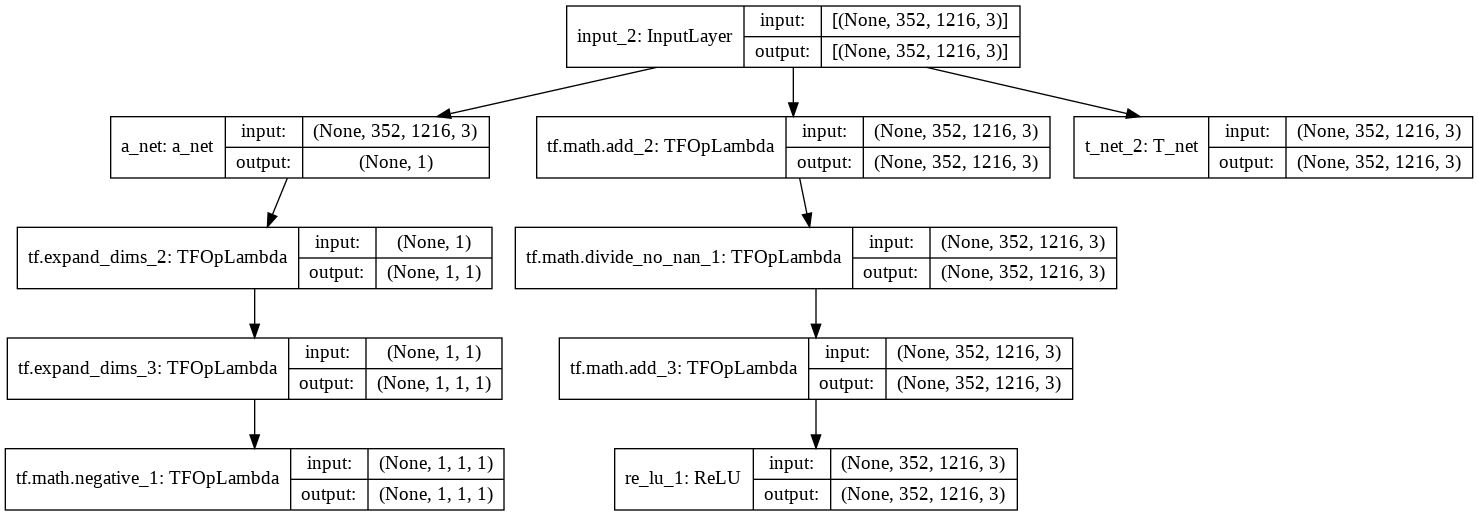

In [6]:
model=Unsuper_net()
#model.save('/content/drive/MyDrive/nets/prelim_model/math_comb')
model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

In [7]:
model.load_weights('/content/drive/MyDrive/nets/prelim_model/math_comb/weights/')

In [ ]:
# Hyperparameters
epochs = 10

k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()
batch_size=2
train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=1)
train, val = dataloader(train_data, val_data, batch_size)
#net = Unsuper_net()
optimizer = Adam(learning_rate = 1e-5)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

5400


In [ ]:
def train_model(epochs, train, val,net,train_loss_tracker,val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                #train_logits = net(train_batch_haze,train_batch_orig,training = True)
                #t=t_net(train_batch_haze)
                #a=a_net(train_batch_haze)
                #out=tf.add(tf.multiply(train_batch_orig,t),tf.multiply(a,(1-t)))
                train_logits=net(train_batch_haze,training=True)
                #loss = mean_squared_error(train_batch_haze,train_logits)
                loss = mean_squared_error(train_batch_orig,train_logits)
                #loss=tf.math.reduce_mean(loss,axis=None)
                #er=tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.AUTO)
                #loss=er(train_batch_orig, train_logits)/batch_size
                #loss=tf.image.psnr(train_batch_orig, train_logits, max_val=1)
                #loss=tf.image.ssim(train_batch_orig, train_logits, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
                #loss=custom_loss(train_batch_haze,out)
                #loss=tf.math.reduce_mean(loss)
                #print(loss)

            grads = tape.gradient(loss,net.trainable_weights)
            #grads2 = tape.gradient(loss,a_net.trainable_weights)
            #optimizer.apply_gradients(zip(grads, t_net.trainable_weights))
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 256 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze,0,False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 256 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        #net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [===========]  -  Training Loss: 0.0004

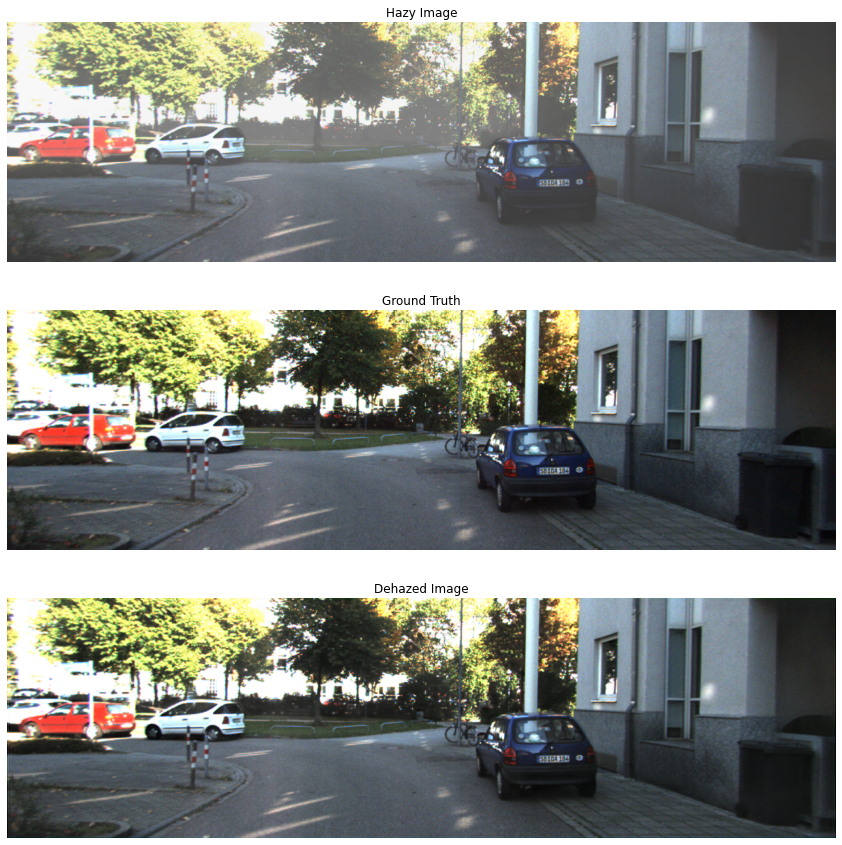

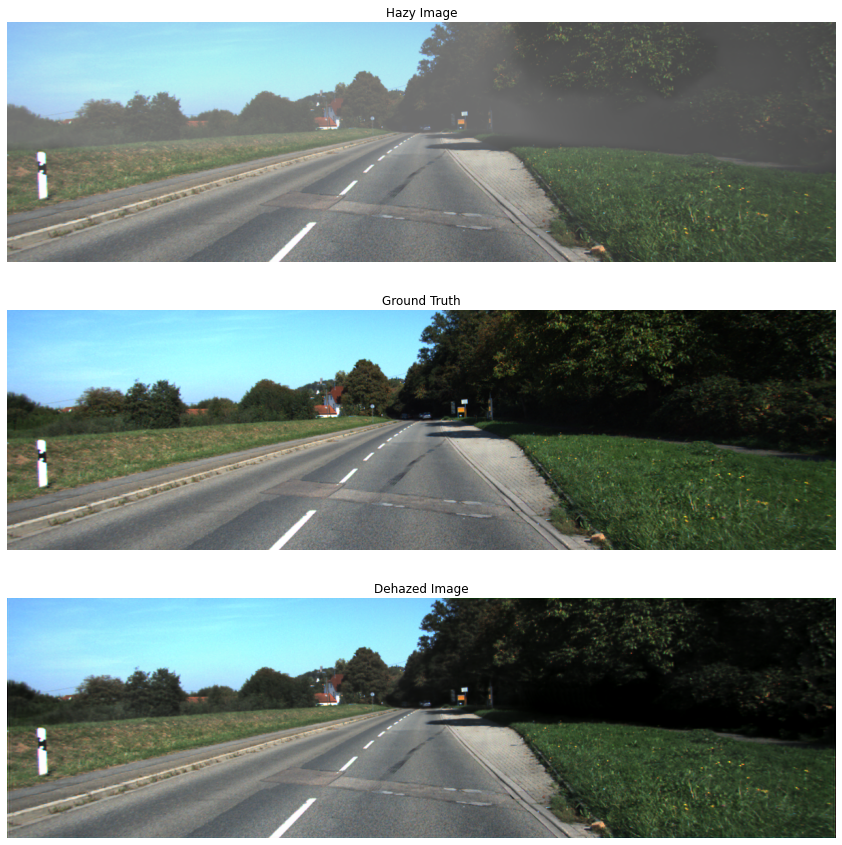

  -  Validation Loss: 0.0007  -   Time taken: 1676.09s
CPU times: user 25min 18s, sys: 2min 12s, total: 27min 31s
Wall time: 27min 56s


In [ ]:
%%time
train_model(1, train, val,model,train_loss_tracker, val_loss_tracker, tf.keras.optimizers.SGD(learning_rate = 1e-13))

In [ ]:
model.save_weights('/content/drive/MyDrive/nets/prelim_model/math_comb/weights/')

In [ ]:
model.layers

In [ ]:
a=load_image('/content/drive/MyDrive/kitti/hazy/0000000005_14_0.81059.png')
o=model.predict(tf.expand_dims(a,axis=0))

In [ ]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/test_set/hazy/*.png')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_png(img, channels = 3)
        
        img = tf.image.resize(img, size = (352,1216), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img)
        
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        #im=((dehaze[0]-0.4)/0.2)*255
        #print(im.numpy().min())
        directory = '/content/drive/MyDrive/test_kitti'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.png'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, im)

        os.chdir('/content')
        i+=1;
        

In [ ]:
evaluate_gen(model)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 

# Testing

In [37]:
path='/content/drive/MyDrive/kitti/hazy/0000000000_12_0.70802.png'
path_trans='/content/drive/MyDrive/kitti/trans/0000000000_12_0.70802.jpg'
i=load_image(path)
o={}
o['Tran']=model.layers[0](tf.expand_dims(i,axis=0))
o['a']=model.layers[1](tf.expand_dims(i,axis=0))

In [38]:
tmap= tf.io.read_file(path_trans)
tmap = tf.io.decode_jpeg(tmap, channels = 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual a value=0.70802
predicted value=0.85952365


(-0.5, 1215.5, 351.5, -0.5)

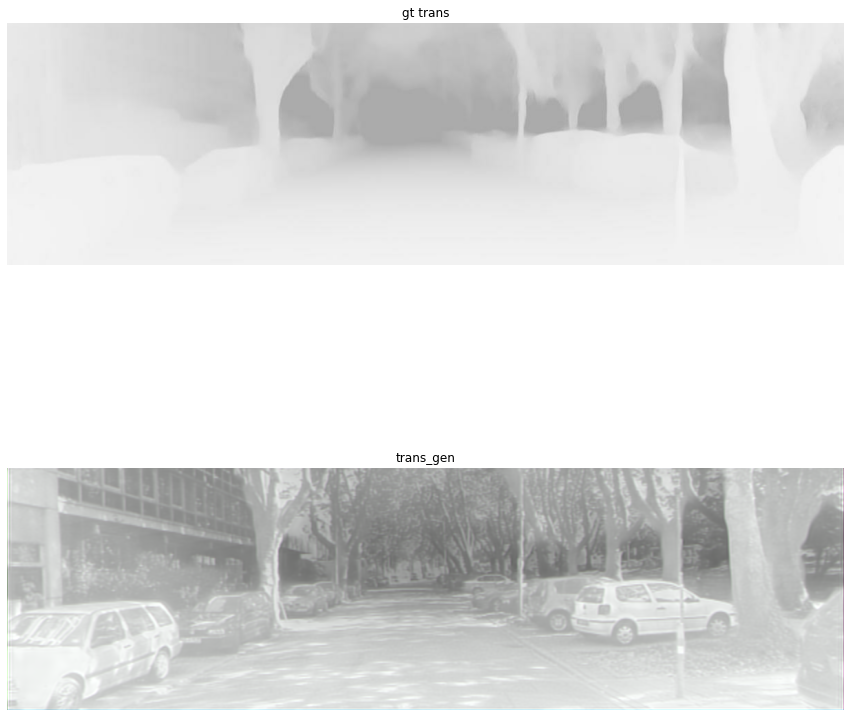

In [54]:
print("actual a value="+path.split('_')[-1][:-4])
print("predicted value="+str(o['a'].numpy()[0][0]))
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.imshow(tmap)
plt.title("gt trans")
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(o['Tran'][0])
plt.title("trans_gen")
plt.axis('off')


In [20]:
get_1st_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])

TypeError: ignored

In [19]:
get_1st_layer_output(tf.expand_dims(a,axis=0))

[array([[0.90959954]], dtype=float32)]

In [9]:
ls /content/drive/MyDrive/kitti/hazy/0000000324_19_0.86383.png

0000000000_12_0.70802.png  0000000333_15_0.79947.png  0000000666_18_0.83518.png
0000000000_14_0.62899.png  0000000333_16_0.97415.png  0000000666_26_0.70357.png
0000000000_19_1.02.png     0000000333_17_0.90086.png  0000000667_11_0.69538.png
0000000000_22_0.57666.png  0000000333_17_0.91101.png  0000000667_13_0.57101.png
0000000000_26_0.72137.png  0000000334_13_0.27061.png  0000000667_19_0.36435.png
0000000000_28_0.55315.png  0000000334_14_0.67127.png  0000000667_19_0.5451.png
0000000001_10_0.91337.png  0000000334_18_0.85463.png  0000000667_21_0.86044.png
0000000001_13_0.99833.png  0000000334_19_0.57614.png  0000000667_25_0.37411.png
0000000001_16_1.1447.png   0000000334_21_0.9603.png   0000000668_13_0.63218.png
0000000001_17_0.88264.png  0000000334_26_0.71938.png  0000000668_17_1.0219.png
0000000001_19_0.73218.png  0000000335_12_0.722.png    0000000668_19_0.72475.png
0000000001_22_0.87365.png  0000000335_12_0.80413.png  0000000668_19_0.74391.png
0000000002_12_0.74949.png  0000000335_13_0